In [56]:
import numpy as np
import pandas as pd
import h5py
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

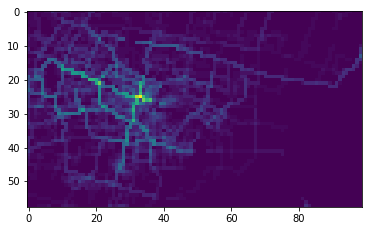

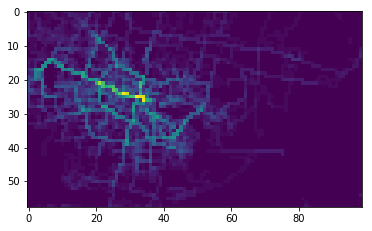

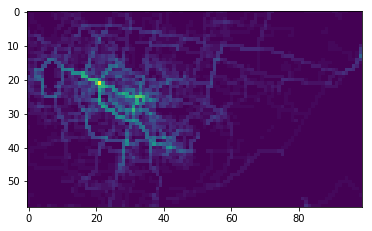

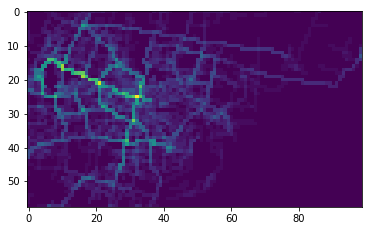

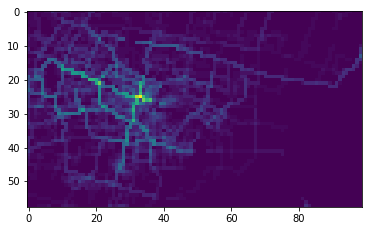

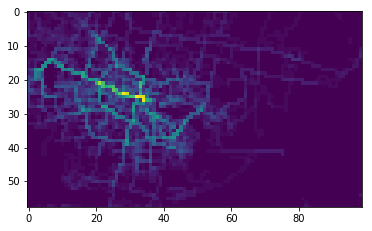

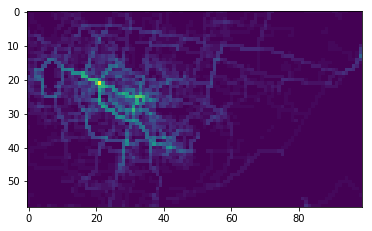

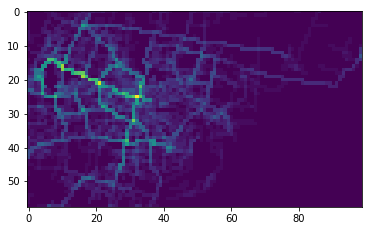

In [36]:
def get_hist():
    frames = []
    for day in range(2, 4):
        hist_file = h5py.File("./data/hist/20170102.h5", "r")
        for key in hist_file.keys():
            plt.imshow(hist_file[key])
            plt.show()
            frames.append(hist_file[key][:])
    return frames
    
data = get_hist()

In [37]:
print(data[0])

[[0 1 2 ... 0 0 0]
 [0 1 2 ... 0 0 0]
 [0 1 2 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [5]:
def get_inputs(real_size, noise_size):
    real_img = tf.placeholder(tf.float32, [None, real_size]
        , name='real_img')
    noise_img = tf.placeholder(tf.float32, [None, noise_size]
        , name='noise_img')
    return real_img, noise_img

In [6]:
def get_generator(noise_img, n_units, out_dim, reuse=False, alpha=0.01):
    with tf.variable_scope("generator", reuse=reuse):
        # hidden layer
        hidden1 = tf.layers.dense(noise_img, n_units)
        # leaky ReLU
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        # dropout
        hidden1 = tf.layers.dropout(hidden1, rate=0.2)
        
        # logits & outputs
        logits = tf.layers.dense(hidden1, out_dim)
        outputs = tf.tanh(logits)
        
        return logits, outputs

In [9]:
def get_discriminator(img, n_units, reuse=False, alpha=0.01):
    with tf.variable_scope("discriminator", reuse=reuse):
        # hidden layer
        hidden1 = tf.layers.dense(img, n_units)
        hidden1 = tf.maximum(alpha * hidden1, hidden1)

        #logits & outputs
        logits = tf.layers.dense(hidden1, 1)
        outputs = tf.sigmoid(logits)
    
    return logits, outputs

In [49]:
img_size = data[0].shape[0] * data[0].shape[1]
print("image size")
print(img_size)

noise_size = 20
g_units = 16
d_units = 16
alpha = 0.01
learning_rate = 0.001
smooth = 0.1

image size
5742


In [50]:
tf.reset_default_graph()

real_img, noise_img = get_inputs(img_size, noise_size)

g_logits, g_outputs = get_generator(noise_img, g_units, img_size)

d_logits_real, d_outputs_real = get_discriminator(real_img, d_units)
d_logits_fake, d_outputs_fake = get_discriminator(g_outputs, d_units, reuse=True)

In [51]:
d_loss_real = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real,
        labels=tf.ones_like(d_logits_real))*(1-smooth))

d_loss_fake = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake,
        labels=tf.zeros_like(d_logits_fake)))

d_loss = tf.add(d_loss_real, d_loss_fake)

g_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake,
        labels=tf.ones_like(d_logits_fake))*(1-smooth))

In [52]:
train_vars = tf.trainable_variables()

g_vars = [var for var in train_vars if var.name.startswith("generator")]
d_vars = [var for var in train_vars if var.name.startswith("discriminator")]

d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

In [53]:
for batch in data:
    batch_images = batch.reshape((1, batch.shape[0]*batch.shape[1]))

In [58]:
batch_size = 1
epochs = 100
n_sample = 2

samples = []
losses = []
saver = tf.train.Saver(var_list = g_vars)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for batch in data:
            batch_images = batch.reshape((batch_size, batch.shape[0]*batch.shape[1]))
            batch_images = batch_images*2 - 1
            
            batch_noise = np.random.uniform(-1, 1, size=(batch_size, noise_size))
            
            sess.run(d_train_opt, feed_dict={real_img:batch_images, noise_img:batch_noise})
            sess.run(g_train_opt, feed_dict={noise_img: batch_noise})
        
        train_loss_d = sess.run(d_loss,
                               feed_dict={real_img: batch_images,
                                          noise_img: batch_noise})
        
        train_loss_d_real = sess.run(d_loss_real,
                                    feed_dict={real_img: batch_images,
                                              noise_img: batch_noise})
        
        train_loss_d_fake = sess.run(d_loss_fake,
                                    feed_dict={real_img: batch_images,
                                              noise_img: batch_noise})
        
        train_loss_g = sess.run(g_loss,
                               feed_dict={noise_img: batch_noise})
        
        print("Epoch {}/{}...".format(e+1, epochs),
             "Discriminator Loss: {:.4f}(Real: {:.4f} + Fake: {:.4f})..."
             .format(train_loss_d, train_loss_d_real, train_loss_d_fake),
             "Generator Loss: {:.4f}".format(train_loss_g))
        losses.append((train_loss_d, train_loss_d_real, train_loss_d_fake, train_loss_g))
        
        sample_noise = np.random.uniform(-1, 1, size=(n_sample, noise_size))
        gen_samples = sess.run(get_generator(noise_img, g_units, img_size, reuse=True),
                              feed_dict={noise_img: sample_noise})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')
        
    with open('train_samples.pkl', 'wb') as f:
        pickle.dump(samples, f)

Epoch 1/100... Discriminator Loss: 1.1967(Real: 0.0000 + Fake: 1.1967)... Generator Loss: 0.3238
Epoch 2/100... Discriminator Loss: 2.9725(Real: 0.0000 + Fake: 2.9725)... Generator Loss: 0.0473
Epoch 3/100... Discriminator Loss: 2.4045(Real: 0.0000 + Fake: 2.4045)... Generator Loss: 0.0852
Epoch 4/100... Discriminator Loss: 3.0879(Real: 0.0000 + Fake: 3.0879)... Generator Loss: 0.0420
Epoch 5/100... Discriminator Loss: 1.6792(Real: 0.0000 + Fake: 1.6792)... Generator Loss: 0.1858
Epoch 6/100... Discriminator Loss: 0.5372(Real: 0.0000 + Fake: 0.5372)... Generator Loss: 0.7903
Epoch 7/100... Discriminator Loss: 0.0627(Real: 0.0000 + Fake: 0.0627)... Generator Loss: 2.5201
Epoch 8/100... Discriminator Loss: 0.8964(Real: 0.0000 + Fake: 0.8964)... Generator Loss: 0.4719
Epoch 9/100... Discriminator Loss: 2.2609(Real: 0.0000 + Fake: 2.2609)... Generator Loss: 0.0991
Epoch 10/100... Discriminator Loss: 1.2153(Real: 0.0000 + Fake: 1.2153)... Generator Loss: 0.3167
Epoch 11/100... Discriminator

Epoch 85/100... Discriminator Loss: 0.4428(Real: 0.0000 + Fake: 0.4428)... Generator Loss: 0.9251
Epoch 86/100... Discriminator Loss: 0.0785(Real: 0.0000 + Fake: 0.0785)... Generator Loss: 2.3250
Epoch 87/100... Discriminator Loss: 0.0237(Real: 0.0000 + Fake: 0.0237)... Generator Loss: 3.3804
Epoch 88/100... Discriminator Loss: 4.7191(Real: 0.0000 + Fake: 4.7191)... Generator Loss: 0.0081
Epoch 89/100... Discriminator Loss: 2.2880(Real: 0.0000 + Fake: 2.2880)... Generator Loss: 0.0963
Epoch 90/100... Discriminator Loss: 0.0980(Real: 0.0000 + Fake: 0.0980)... Generator Loss: 2.1339
Epoch 91/100... Discriminator Loss: 0.5748(Real: 0.0000 + Fake: 0.5748)... Generator Loss: 0.7447
Epoch 92/100... Discriminator Loss: 0.0280(Real: 0.0000 + Fake: 0.0280)... Generator Loss: 3.2293
Epoch 93/100... Discriminator Loss: 1.8867(Real: 0.0000 + Fake: 1.8867)... Generator Loss: 0.1479
Epoch 94/100... Discriminator Loss: 0.5899(Real: 0.0000 + Fake: 0.5899)... Generator Loss: 0.7275
Epoch 95/100... Disc